Pre-required utilities

In [2]:
#pip install notebook

import os
import sys

os.chdir('/Networkx_pipeline/')  # change to the directory that 'utils.py' located in

sys.path.append('')  # add current directory to sys.path

import utils

Directed graph construction based on cross-correlation parameters

In [3]:
from scipy.io import loadmat
import numpy as np

SpikeTrains = loadmat('./Data/sharedNeurons_par2_Viterbi')

# data format: ex_csd / ct1 / (neuron# x time series)
ZeroT=loadmat('./Data/bb_timepoint_for_common_cell_ver231026')

# data format: ROI_ex_csd / ct1 / (neuron# x 3 (x,y,dist from NMDA))
ExCSD_STs=SpikeTrains['ex_csd'][0][0] # (, 3000)
ExLocal_STs=SpikeTrains['ex_local'][0][0] # (, 3000)
InCSD_STs=SpikeTrains['in_csd'][0][0] # (,3000)
InLocal_STs=SpikeTrains['in_local'][0][0] # (,3000)

Tot_STs=[ExCSD_STs, ExLocal_STs, InCSD_STs, InLocal_STs]
Tot_STsName=['ExCSD_STs', 'ExLocal_STs', 'InCSD_STs', 'InLocal_STs']
Tot_ZeroT=[ZeroT['time_ex']['csd'],ZeroT['time_ex']['local'],ZeroT['time_in']['csd'],ZeroT['time_in']['local']]

AnalyzedWindow=2400


for i in range (len(Tot_STs)):
    globals()["{}_noCt".format(Tot_STsName[i])]=np.empty((0)).tolist()
    for j in range (len(Tot_STs[i].dtype.names)):
        globals()["{}_noCt".format(Tot_STsName[i])]+=list(Tot_STs[i][Tot_STs[i].dtype.names[j]][:,Tot_ZeroT[i][0][0][j][0]:Tot_ZeroT[i][0][0][j][0]+AnalyzedWindow])
    globals()["{}_noCt".format(Tot_STsName[i])]=np.vstack(globals()["{}_noCt".format(Tot_STsName[i])])

Cum_Num_st=np.empty((len(Tot_STs), 0)).tolist()
Num_st_neuron=np.empty((len(Tot_STs), 0)).tolist()

for i in range (0,len(Tot_STs)):
    for j in range (0, len(Tot_STs[i])+1):
        if j<len(Tot_STs[i]):
            Num_st_neuron[i]+=[len(Tot_STs[i][j])]
        if j==0:
            Cum_Num_st[i]+=[0]
        else:
            Cum_Num_st[i]+=[Cum_Num_st[i][j-1]+Num_st_neuron[i][j-1]]            
            
            
for i in range (0, len(Num_st_neuron)):
    for j in range (1, len(Num_st_neuron[i])+1):
        if i==0:
            globals()["W_ex_csd_ct{}".format(j)]=utils.AddCrCorredge(ExCSD_STs_noCt[Cum_Num_st[i][j-1]:Cum_Num_st[i][j],:])
        elif i==1:
            globals()["W_ex_local_ct{}".format(j)]=utils.AddCrCorredge(ExLocal_STs_noCt[Cum_Num_st[i][j-1]:Cum_Num_st[i][j],:])
        elif i==2:
            globals()["W_in_csd_ct{}".format(j)]=utils.AddCrCorredge(InCSD_STs_noCt[Cum_Num_st[i][j-1]:Cum_Num_st[i][j],:])
        elif i==3:
            globals()["W_in_local_ct{}".format(j)]=utils.AddCrCorredge(InLocal_STs_noCt[Cum_Num_st[i][j-1]:Cum_Num_st[i][j],:])
        else:
            break

W_Ex_CSD=[]
W_Ex_Local=[]
W_In_CSD=[]
W_In_Local=[]

for i in range (0, len(Num_st_neuron)):
    for j in range (1, len(Num_st_neuron[i])+1):
        if i==0:
            W_Ex_CSD+=[globals()["W_ex_csd_ct{}".format(j)]]
        elif i==1:
            W_Ex_Local+=[globals()["W_ex_local_ct{}".format(j)]]
        elif i==2:
            W_In_CSD+=[globals()["W_in_csd_ct{}".format(j)]]
        elif i==3:
            W_In_Local+=[globals()["W_in_local_ct{}".format(j)]]
        else:
            break

        #nx.draw(w[i],with_labels=True)

w=[W_Ex_CSD, W_Ex_Local, W_In_CSD, W_In_Local]

/Volumes/김하연/백업/Toolbox/Networkx_pipeline/utils.py:104: RuntimeWarning: invalid value encountered in sqrt
  t_value = correlation* np.sqrt(float( df / (1 - correlation**2)))


Tau-peak cross-corr parameters relation graph

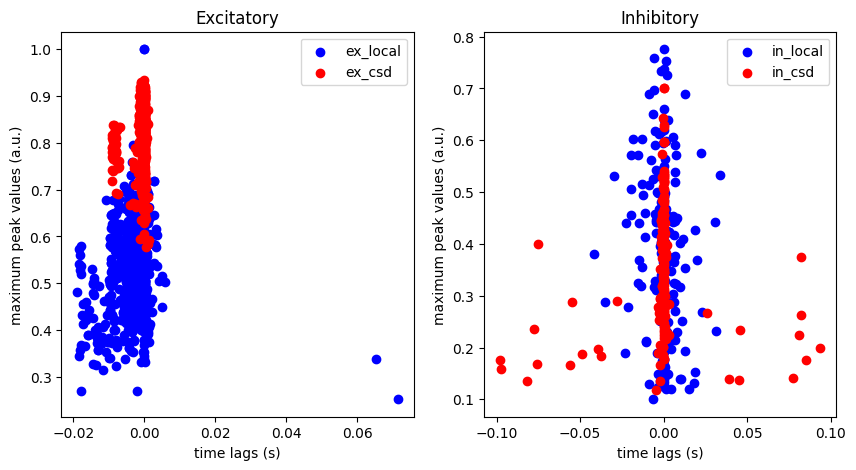

In [3]:
# Tau-peak cross corr value relation graph

import matplotlib.pyplot as plt

ex_csd_CrossTauPlot=[[],[]]
ex_local_CrossTauPlot=[[],[]]
in_csd_CrossTauPlot=[[],[]]
in_local_CrossTauPlot=[[],[]]

for i in range (0, len(Num_st_neuron)):
    for j in range (1, len(Num_st_neuron[i])+1):
        if i==0:
            x=ExCSD_STs_noCt[Cum_Num_st[i][j-1]:Cum_Num_st[i][j],:]
            for i in range (len(x[:,0])): # neuron#
                for j in range (i+1,len(x[:,0]+1)): 
                    timeshift, p, peaks= utils.cross_corr_Tshift(x[i,:], x[j,:])
                    if timeshift==None or p==None or p>0.05:
                        continue
                    else:
                        ex_csd_CrossTauPlot[0].append(timeshift)
                        ex_csd_CrossTauPlot[1].append(peaks)                        
        elif i==1:
            x=ExLocal_STs_noCt[Cum_Num_st[i][j-1]:Cum_Num_st[i][j],:]
            for i in range (len(x[:,0])): # neuron#
                for j in range (i+1,len(x[:,0]+1)): 
                    timeshift, p, peaks= utils.cross_corr_Tshift(x[i,:], x[j,:])
                    if timeshift==None or p==None or p>0.05:
                        continue
                    else:
                        ex_local_CrossTauPlot[0].append(timeshift)
                        ex_local_CrossTauPlot[1].append(peaks)          
        elif i==2:
            x=InCSD_STs_noCt[Cum_Num_st[i][j-1]:Cum_Num_st[i][j],:]
            for i in range (len(x[:,0])): # neuron#
                for j in range (i+1,len(x[:,0]+1)): 
                    timeshift, p, peaks= utils.cross_corr_Tshift(x[i,:], x[j,:])
                    if timeshift==None or p==None or p>0.05:
                        continue
                    else:
                        in_csd_CrossTauPlot[0].append(timeshift)
                        in_csd_CrossTauPlot[1].append(peaks) 
        elif i==3:
            x=InLocal_STs_noCt[Cum_Num_st[i][j-1]:Cum_Num_st[i][j],:]
            for i in range (len(x[:,0])): # neuron#
                for j in range (i+1,len(x[:,0]+1)): 
                    timeshift, p, peaks= utils.cross_corr_Tshift(x[i,:], x[j,:])
                    if timeshift==None or p==None or p>0.05:
                        continue
                    else:
                        in_local_CrossTauPlot[0].append(timeshift)
                        in_local_CrossTauPlot[1].append(peaks) 
        else:
            break





Tauplot = [ex_csd_CrossTauPlot, ex_local_CrossTauPlot, in_csd_CrossTauPlot, in_local_CrossTauPlot]


#fig, axs = plt.subplots(1, len(Tauplot), figsize=(20, 5))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

x = Tauplot[1][0]
y = Tauplot[1][1]
axs[0].scatter(x, y, color = 'blue', label = 'ex_local')
x = Tauplot[0][0]
y = Tauplot[0][1]
axs[0].scatter(x, y, color = 'red', label = 'ex_csd')

axs[0].set_xlabel("time lags (s)")
axs[0].set_ylabel("maximum peak values (a.u.)")
axs[0].legend()
axs[0].set_title('Excitatory')


x = Tauplot[3][0]
y = Tauplot[3][1]
axs[1].scatter(x, y, color = 'blue', label = 'in_local')
x = Tauplot[2][0]
y = Tauplot[2][1]
axs[1].scatter(x, y, color = 'red', label = 'in_csd')

axs[1].set_xlabel("time lags (s)")
axs[1].set_ylabel("maximum peak values (a.u.)")
axs[1].legend()
axs[1].set_title('Inhibitory')


plt.show()

Computing network characters
- Degree
- Assortativity
- Between Centrality
- Closeness Centrality
- Density
- Shortest Path
- Weight
- Eigen Centrality
- Average distance of every nodes

In [4]:
from collections import Counter
import networkx as nx

for i in range (0, len(w)):
    globals()[utils.retrieve_name(w[i])[0]+"_degDevlen"]=[]
    globals()[utils.retrieve_name(w[i])[0]+"_assort"]=[]
    globals()[utils.retrieve_name(w[i])[0]+"_bet_cent"]=[]
    globals()[utils.retrieve_name(w[i])[0]+"_clos_cent"]=[]
    globals()[utils.retrieve_name(w[i])[0]+"_clst_coeff"]=[]
    globals()[utils.retrieve_name(w[i])[0]+"_density"]=[]
    globals()[utils.retrieve_name(w[i])[0]+"_shortest_path"]=[]
    globals()[utils.retrieve_name(w[i])[0]+"_weight"]=[]
    globals()[utils.retrieve_name(w[i])[0]+"_ei_cent"]=[]
    globals()[utils.retrieve_name(w[i])[0]+"_node_average_distance"]=[[],[]]
    
    for j in range (0, len(w[i])):
        
        globals()[utils.retrieve_name(w[i])[0]+"_density"].append(nx.density(w[i][j]))
        
        # Normalized Link plotted from nearest node
        globals()[utils.retrieve_name(w[i])[0]+"_degDevlen"]+=list(np.array(w[i][j].degree())[:,1]/(len(w[i][j])-1))


        # Link distribution bar graph
        degree_sequence = [w[i][j].degree(n) for n in w[i][j].nodes]
        degree_counts = Counter(degree_sequence)
        #globals()[retrieve_name(w[i])[0]+"_degree_counts"]+=degree_counts/len(w[i][j])


        # Assortativity 
        r=nx.degree_assortativity_coefficient(w[i][j])
        globals()[utils.retrieve_name(w[i])[0]+"_assort"].append(r)


        # Clustering coefficient
        globals()[utils.retrieve_name(w[i])[0]+"_clst_coeff"].append(nx.average_clustering(w[i][j]))
        
        
        # Centrality of each neurons   
        globals()[utils.retrieve_name(w[i])[0]+"_bet_cent"]+=nx.betweenness_centrality(w[i][j], weight='distance').values()
        globals()[utils.retrieve_name(w[i])[0]+"_clos_cent"]+=nx.closeness_centrality(w[i][j], distance='distance').values()                                                                                           
        
        
        # Weight distribution
        globals()[utils.retrieve_name(w[i])[0]+"_weight"]+=list(nx.get_edge_attributes(w[i][j],'weight').values())
        

        # Average weight distribution of each nodes
        for sourcenodes in list(range(1, len(w[i][j])+1)):
            from_node_weight_list=[]
            toward_node_weight_list=[]
            for targetnodes in list(range(1, len(w[i][j])+1)):
                if sourcenodes!=targetnodes:
                    if nx.is_path(w[i][j], (sourcenodes, targetnodes)):
                        from_node_weight_list+=[w[i][j][sourcenodes][targetnodes]['distance']]
                    elif nx.is_path(w[i][j], (targetnodes, sourcenodes)):
                        toward_node_weight_list+=[w[i][j][targetnodes][sourcenodes]['distance']]
                    else:
                        continue
            if from_node_weight_list !=[]:
                globals()[utils.retrieve_name(w[i])[0]+"_node_average_distance"][0]+=[np.mean(from_node_weight_list)]
            if toward_node_weight_list!=[]:
                globals()[utils.retrieve_name(w[i])[0]+"_node_average_distance"][1]+=[np.mean(toward_node_weight_list)]
        
        
        # Shortest path
        graph=dict(nx.all_pairs_bellman_ford_path_length(w[i][j], weight='distance'))
        values_list=[]
        values_list = [[graph[key][target] for target in range(1, Num_st_neuron[i][j-1]+1) if key in graph and target in graph[key]]  if key < Num_st_neuron[i][j-1]+1 else [] for key in range(1, Num_st_neuron[i][j-1]+1)]
        shortest_paths=[item for sublist in values_list for item in sublist]
        for m in shortest_paths:
            if m!=0:
                globals()[utils.retrieve_name(w[i])[0]+"_shortest_path"].append(m)
                
                
        # Eigenvector centrality
        globals()[utils.retrieve_name(w[i])[0]+"_ei_cent"]+=nx.eigenvector_centrality(w[i][j],weight='weight').values()

                
                
# Substraction and appearing/disappearing info. between local & csd

GroupName=['CSD', 'Local']

# Additional info.) Variable[0]==CSD-Local, variable[1]==Only CSD, variable[2]==Only Local

for i in range (0, 2):
    globals()[GroupName[i]+"_shortest_path_GroupSubtract"]=[[],[],[],[[],[]],[[],[]],[[],[]]]
    globals()[GroupName[i]+"_weight_GroupSubtract"]=[[],[],[]]
    globals()[GroupName[i]+"_distance_GroupSubtract"]=[[],[],[]]
    
    n_stackedNode=0
    for j in range (0, len(w[2*i])):
        #shortest_path
        graph_csd=dict(nx.all_pairs_bellman_ford_path_length(w[2*i][j], weight='distance'))
        graph_local=dict(nx.all_pairs_bellman_ford_path_length(w[2*i+1][j], weight='distance'))
        for sourcenodes in list(range(1, len(w[2*i+1][j])+1)):
            for targetnodes in list(range(1, len(w[2*i+1][j])+1)):
                if sourcenodes!=targetnodes:
                    if nx.has_path(w[2*i][j], sourcenodes, targetnodes) and nx.has_path(w[2*i+1][j], sourcenodes, targetnodes):
                        globals()[GroupName[i]+"_shortest_path_GroupSubtract"][0].append(graph_csd[sourcenodes][targetnodes]-graph_local[sourcenodes][targetnodes])
                        globals()[GroupName[i]+"_shortest_path_GroupSubtract"][3][0].append(n_stackedNode+sourcenodes)
                        globals()[GroupName[i]+"_shortest_path_GroupSubtract"][3][1].append(n_stackedNode+targetnodes)
                    elif nx.has_path(w[2*i][j], sourcenodes, targetnodes):
                        globals()[GroupName[i]+"_shortest_path_GroupSubtract"][1].append(graph_csd[sourcenodes][targetnodes])
                        globals()[GroupName[i]+"_shortest_path_GroupSubtract"][4][0].append(n_stackedNode+sourcenodes)
                        globals()[GroupName[i]+"_shortest_path_GroupSubtract"][4][1].append(n_stackedNode+targetnodes)
                    elif nx.has_path(w[2*i+1][j], sourcenodes, targetnodes):
                        globals()[GroupName[i]+"_shortest_path_GroupSubtract"][2].append(graph_local[sourcenodes][targetnodes])
                        globals()[GroupName[i]+"_shortest_path_GroupSubtract"][5][0].append(n_stackedNode+sourcenodes)
                        globals()[GroupName[i]+"_shortest_path_GroupSubtract"][5][1].append(n_stackedNode+targetnodes)
                    else:
                        continue
        
        
        # Weight
        
        for sourcenodes in list(range(1, len(w[2*i+1][j])+1)):
            for targetnodes in list(range(1, len(w[2*i+1][j])+1)):
                weight_csd=[]
                weight_local=[]
                if sourcenodes!=targetnodes:            
                    if  w[2*i][j].has_edge(sourcenodes, targetnodes) and w[2*i+1][j].has_edge(sourcenodes, targetnodes):
                        weight_csd=w[2*i][j][sourcenodes][targetnodes]['weight']
                        weight_local=w[2*i+1][j][sourcenodes][targetnodes]['weight']
                        globals()[GroupName[i]+"_weight_GroupSubtract"][0].append(weight_csd-weight_local)
                        globals()[GroupName[i]+"_distance_GroupSubtract"][0].append(1/weight_csd-1/weight_local)
                    elif w[2*i][j].has_edge(sourcenodes, targetnodes):
                        weight_csd=w[2*i][j][sourcenodes][targetnodes]['weight']
                        globals()[GroupName[i]+"_weight_GroupSubtract"][1].append(weight_csd)
                        globals()[GroupName[i]+"_distance_GroupSubtract"][1].append(1/weight_csd)
                    elif w[2*i+1][j].has_edge(sourcenodes, targetnodes):
                        weight_local=w[2*i+1][j][sourcenodes][targetnodes]['weight']
                        globals()[GroupName[i]+"_weight_GroupSubtract"][2].append(weight_local)
                        globals()[GroupName[i]+"_distance_GroupSubtract"][2].append(1/weight_local)
                    else:
                        continue
                        
        n_stackedNode+=len(w[2*i+1][j])

Weight distribution

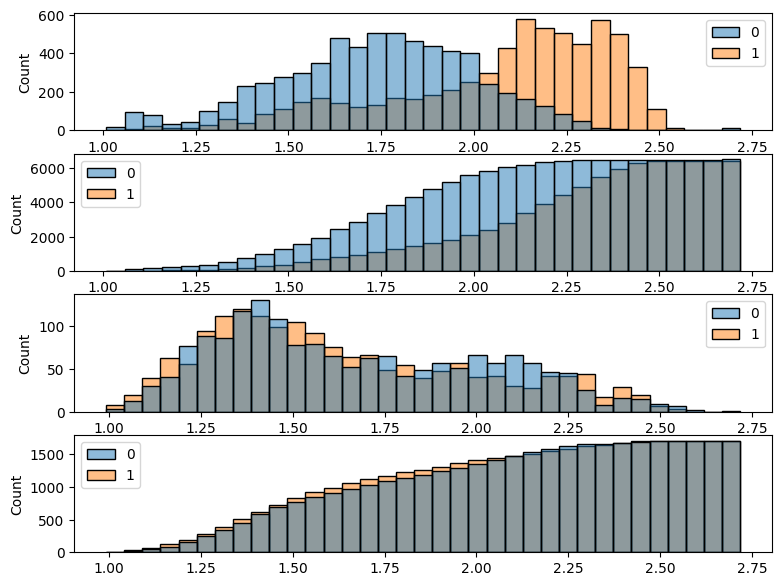

one way t_stat= 61.86913920443257 p_value= 0.0
Wilcoxon statistic:  826054.0 p_value= 0.0
one way t_stat= -3.809925250164948 p_value= 0.00014673981138223132
Wilcoxon statistic:  268708.0 p_value= 0.0023610460135014173


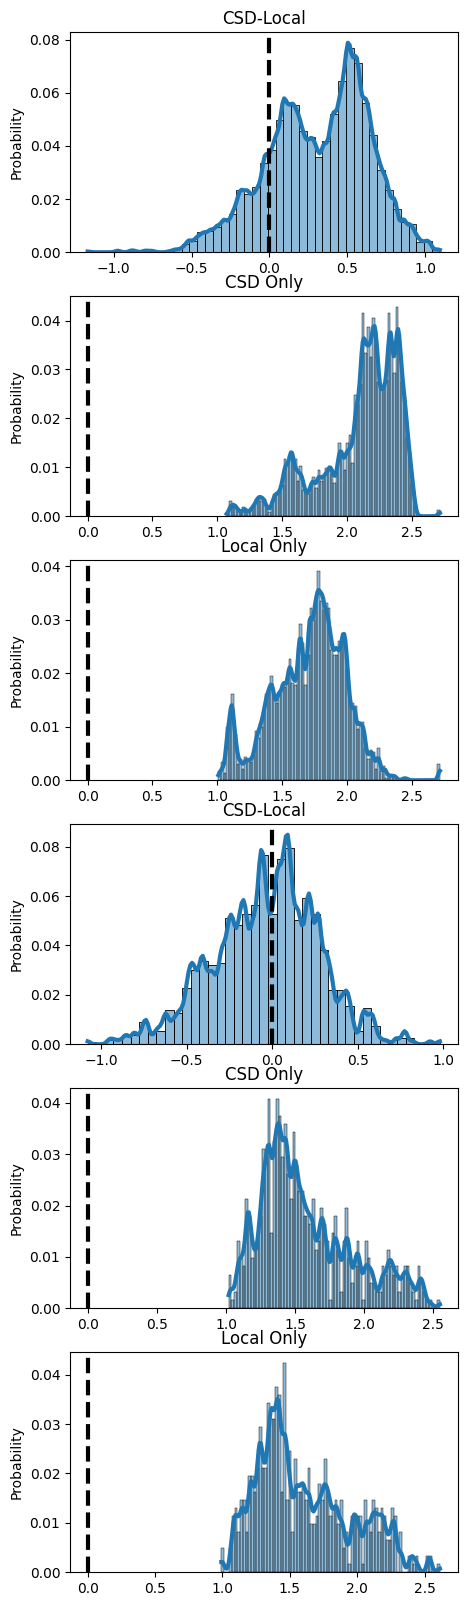

In [5]:
import seaborn as sns
from scipy import stats
from scipy.stats import wilcoxon

# Make histogram
fig, axs = plt.subplots(4, 1, figsize=(9, 7))  # Makes vertically located subplots 
for i in range (2):
    sns.histplot([globals()[utils.retrieve_name(w[2*i+1])[0]+"_weight"], globals()[utils.retrieve_name(w[2*i])[0]+"_weight"]], binwidth=0.05, ax=axs[2*i])  # Draw graph at i'th subplot
    sns.histplot([globals()[utils.retrieve_name(w[2*i+1])[0]+"_weight"], globals()[utils.retrieve_name(w[2*i])[0]+"_weight"]], cumulative=True, binwidth=0.05, ax=axs[2*i+1])  # Draw graph at i'th subplot

plt.show()        


weight_tot_mat=[]

# Subtracted form
fig, axs = plt.subplots(6, 1, figsize=(5, 20))  # Makes len(TotPath) vertically located subplots 
for i in range (2):
    sns.histplot(globals()[GroupName[i]+"_weight_GroupSubtract"][0], binwidth=0.05, stat='probability', kde_kws={'bw_method': 0.05}, line_kws={'lw': 3},kde=True, ax=axs[3*i]) 
    weight_tot_mat+=[globals()[GroupName[i]+"_weight_GroupSubtract"][0]]
    axs[3*i].set_title("CSD-Local")
    sns.histplot(globals()[GroupName[i]+"_weight_GroupSubtract"][1], binwidth=0.02, stat='probability', kde_kws={'bw_method': 0.05}, line_kws={'lw': 3},kde=True, ax=axs[3*i+1]) 
    weight_tot_mat+=[globals()[GroupName[i]+"_weight_GroupSubtract"][1]]
    axs[3*i+1].set_title("CSD Only")
    sns.histplot(globals()[GroupName[i]+"_weight_GroupSubtract"][2], binwidth=0.02, stat='probability', kde_kws={'bw_method': 0.05}, line_kws={'lw': 3},kde=True, ax=axs[3*i+2])
    weight_tot_mat+=[globals()[GroupName[i]+"_weight_GroupSubtract"][2]]
    axs[3*i+2].set_title("Local Only")
    
    axs[3*i].axvline(x=0, color='black', linestyle='--', linewidth=3)
    axs[3*i+1].axvline(x=0, color='black', linestyle='--', linewidth=3)
    axs[3*i+2].axvline(x=0, color='black', linestyle='--', linewidth=3)
    
    statistic, pvalue = stats.ttest_1samp(globals()[GroupName[i]+"_weight_GroupSubtract"][0], 0)
    print('one way t_stat=',statistic, 'p_value=',pvalue)
    statistic, pvalue = wilcoxon(globals()[GroupName[i]+"_weight_GroupSubtract"][0])
    print('Wilcoxon statistic: ',statistic, 'p_value=',pvalue)

plt.show()   

Network for hub detection

In [6]:
import networkx as nx
import numpy as np

high_degree_hub_list = np.empty((len(w), 0)).tolist()
w_filtered = np.empty((len(w), 0)).tolist()

for i in range(len(w)):
    for j in range(len(w[i])):

        # Retain only the top 10% of edges based on weight
        threshold = np.percentile([data['weight'] for u, v, data in w[i][j].edges(data=True)], 90)
        
        filtered_edges = [(u, v) for u, v, data in w[i][j].edges(data=True) if data['weight'] >= threshold]

        # Make new directed graph
        filtered_graph = nx.DiGraph()
        filtered_graph.add_edges_from(filtered_edges)
        
        # Add existing nodes
        filtered_graph.add_nodes_from(w[i][j].nodes)
        
        # Save at w_filtered
        w_filtered[i].append(filtered_graph)

        # Compute the in-degree and out-degree of the node
        in_degrees = filtered_graph.in_degree()
        out_degrees = filtered_graph.out_degree()

        num_nodes = filtered_graph.number_of_nodes()
        degree_threshold = 0.3 * (num_nodes - 1)

        # Filter and align the node that sum of in-degree & out-degree exceeding threshold
        combined_degrees = {node: in_degrees[node] + out_degrees[node] for node in filtered_graph.nodes}
        high_degree_nodes = [node for node, degree in combined_degrees.items() if degree >= degree_threshold]
        high_degree_nodes.sort(key=lambda node: combined_degrees[node], reverse=True)

        # Add filtered node to the list
        high_degree_hub_list[i].append(high_degree_nodes)

        print(f"Graph ({i}, {j}):")
        print(f"Number of nodes: {num_nodes}")
        print(f"High combined degree nodes: {high_degree_nodes}")


Graph (0, 0):
Number of nodes: 39
High combined degree nodes: [22, 24]
Graph (0, 1):
Number of nodes: 29
High combined degree nodes: [27, 21, 24]
Graph (0, 2):
Number of nodes: 41
High combined degree nodes: [20, 26, 33, 34]
Graph (0, 3):
Number of nodes: 46
High combined degree nodes: [30, 16, 18, 20, 26]
Graph (0, 4):
Number of nodes: 44
High combined degree nodes: [31, 21, 22, 28]
Graph (0, 5):
Number of nodes: 50
High combined degree nodes: [31, 15, 19, 20, 38, 46, 30, 40]
Graph (0, 6):
Number of nodes: 44
High combined degree nodes: [43, 27, 16, 32, 38, 25, 17]
Graph (0, 7):
Number of nodes: 38
High combined degree nodes: [35, 32, 18]
Graph (1, 0):
Number of nodes: 39
High combined degree nodes: [31, 24, 34]
Graph (1, 1):
Number of nodes: 29
High combined degree nodes: [13, 19]
Graph (1, 2):
Number of nodes: 41
High combined degree nodes: [22, 23]
Graph (1, 3):
Number of nodes: 46
High combined degree nodes: [42, 28]
Graph (1, 4):
Number of nodes: 44
High combined degree nodes: [4

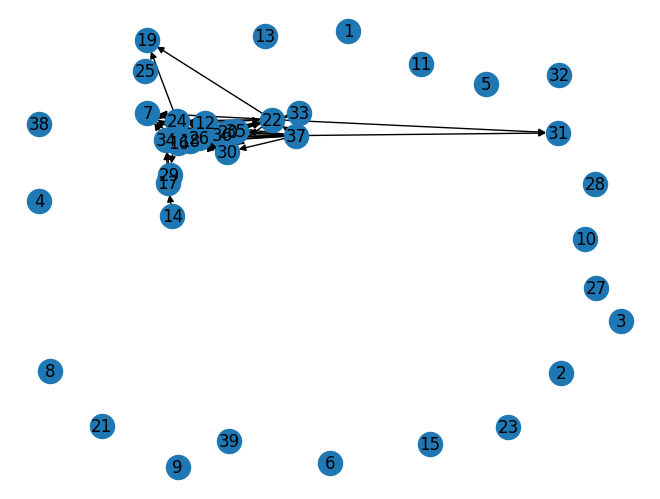

In [7]:
# Plot the example filtered graph
nx.draw(w_filtered[0][0],with_labels=True)

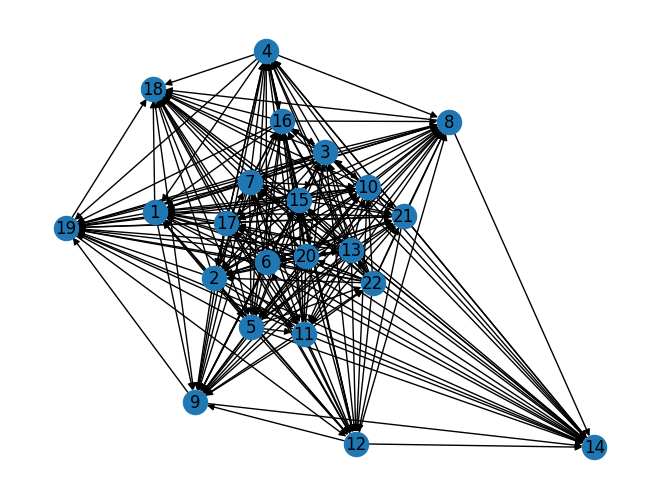

In [8]:
# Plot the example initial graph
nx.draw(w[3][3],with_labels=True)

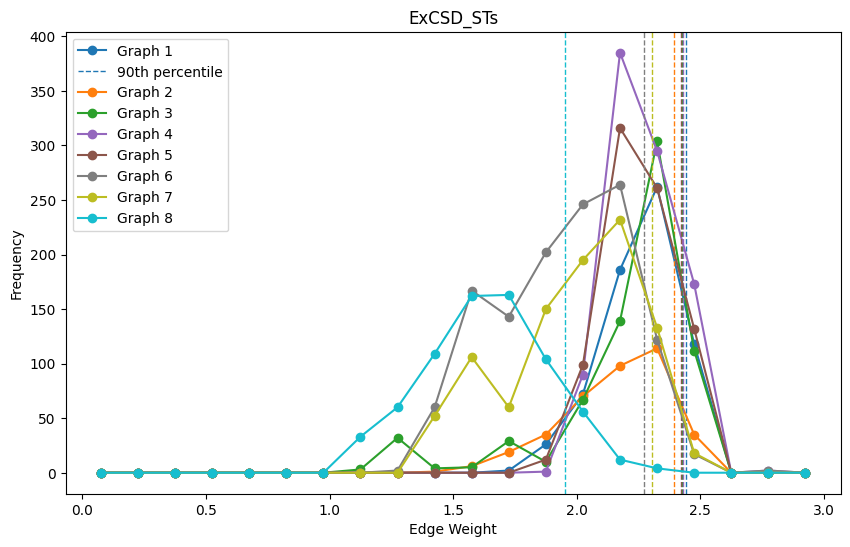

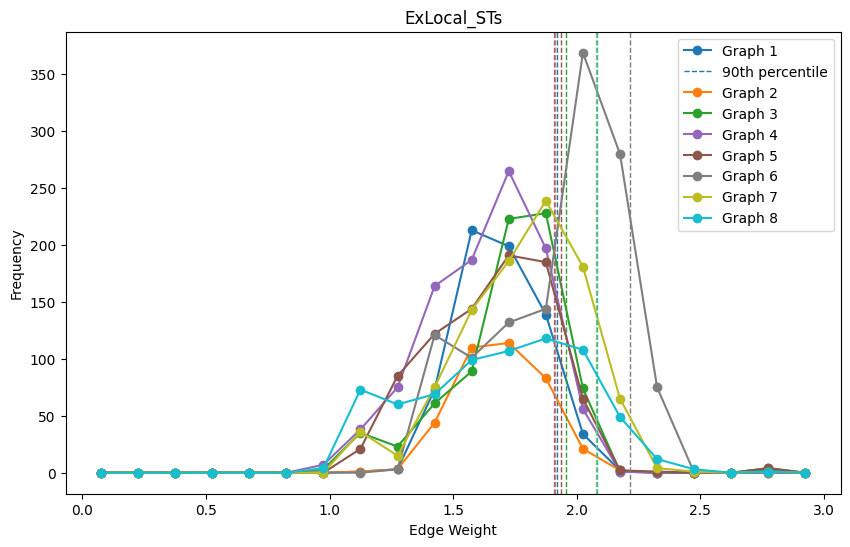

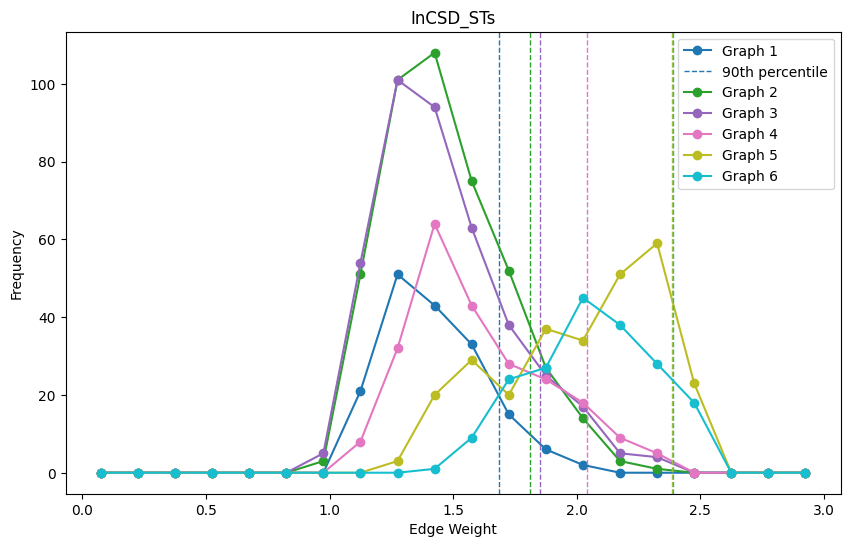

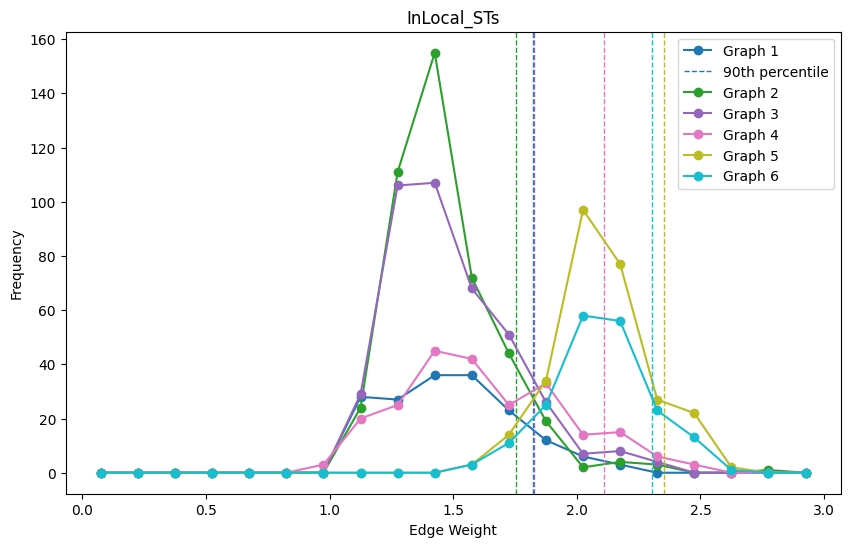

In [9]:
# Plot the edge weight distribution of each graph and add the vertical line to node with top 10% highest weight
for row_index, graphs in enumerate(w):
    utils.plot_weight_distribution(graphs, row_index, title=Tot_STsName[row_index])

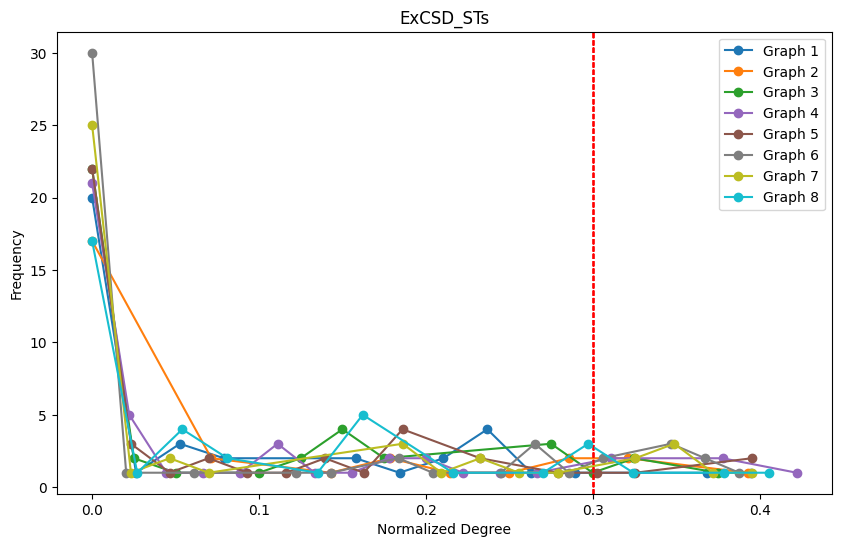

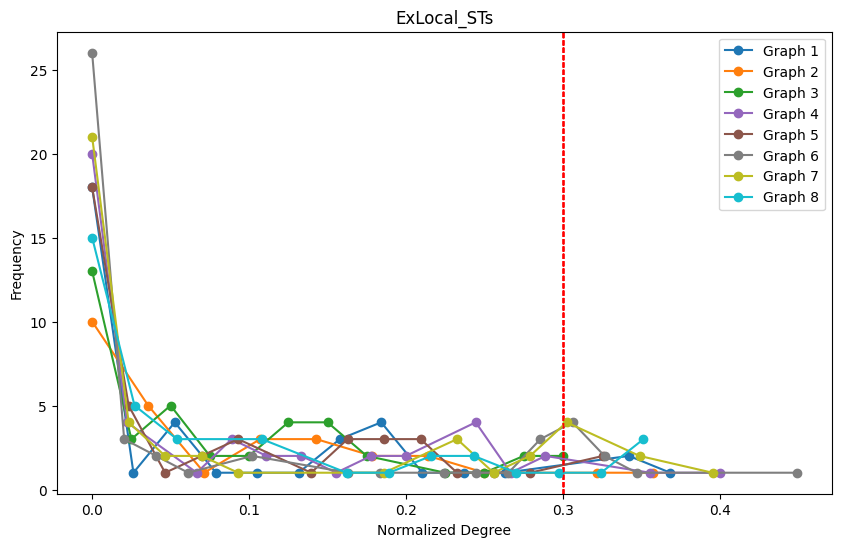

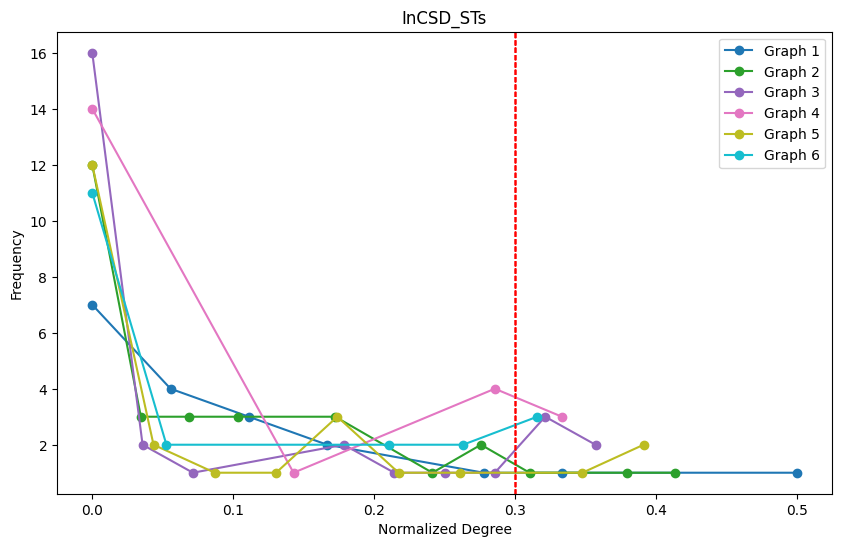

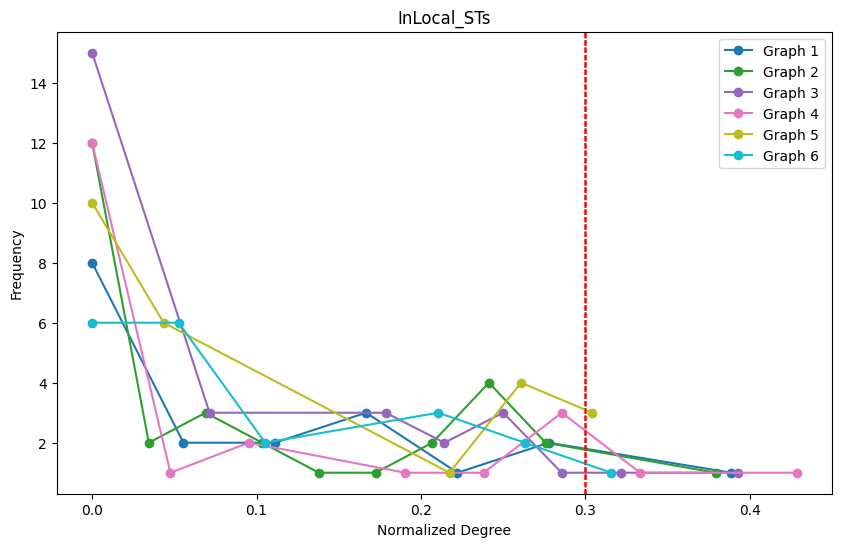

In [10]:
# Plot the normalized degree distibution of filtered graph & add the vertical line to degree number referring 30% of nodes in the graph
for row_index, graphs in enumerate(w_filtered):
    utils.plot_degree_distribution(graphs, row_index, title=Tot_STsName[row_index])

Average connectivity strength divided by the case of hub/non-hub

Mann-Whitney U test results for row 0: U=7134.0, p-value=0.0001343345064166324


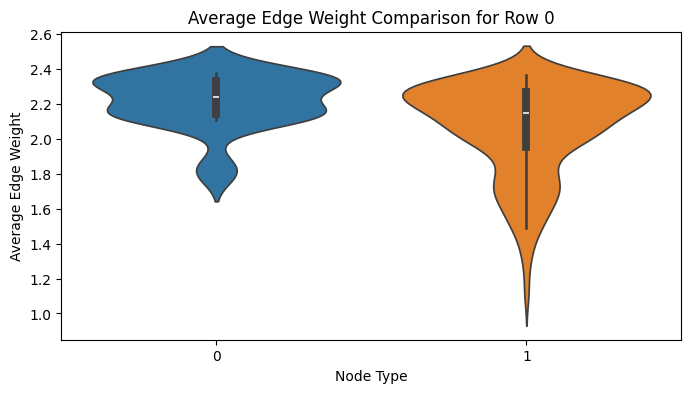

Mann-Whitney U test results for row 1: U=7706.0, p-value=7.463530909423358e-12


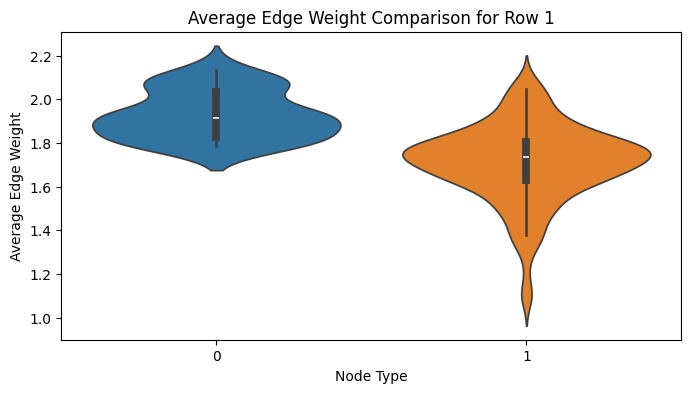

Mann-Whitney U test results for row 2: U=1835.0, p-value=0.00013385323515017819


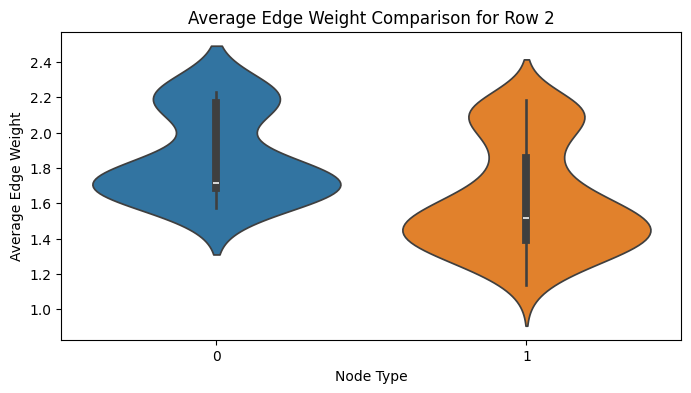

Mann-Whitney U test results for row 3: U=1067.0, p-value=0.001833204805851194


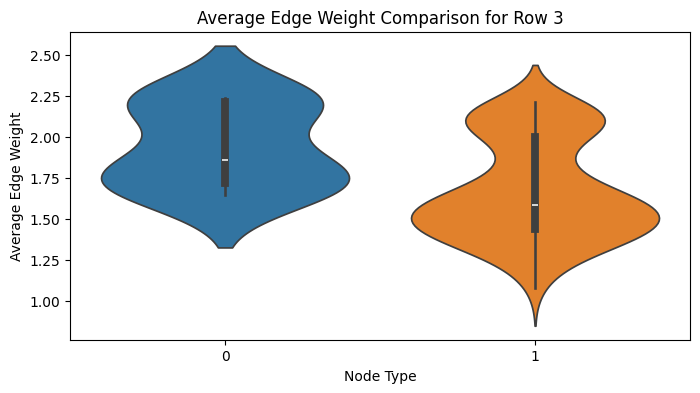

In [11]:
import pandas as pd

# Collect all weights
all_hub_weights = []
all_other_weights = []

for row_index, graphs in enumerate(w):
    hub_weights, other_weights = utils.plot_average_weights(row_index, graphs, high_degree_hub_list)
    all_hub_weights.append(hub_weights)
    all_other_weights.append(other_weights)

# Prepare data for Excel
data = {
    'Row Index': [],
    'Node Type': [],
    'Average Edge Weight': []
}

for row_index, (hub_weights, other_weights) in enumerate(zip(all_hub_weights, all_other_weights)):
    data['Row Index'].extend([row_index] * len(hub_weights))
    data['Node Type'].extend(['Hub'] * len(hub_weights))
    data['Average Edge Weight'].extend(hub_weights)
    
    data['Row Index'].extend([row_index] * len(other_weights))
    data['Node Type'].extend(['Non-Hub'] * len(other_weights))
    data['Average Edge Weight'].extend(other_weights)

# Create DataFrame
df = pd.DataFrame(data)

# Save to Excel
df.to_excel('C:/Users/user/Desktop/A first course in network science/240625_hubNonhub_average_edge_weights.xlsx', index=False)

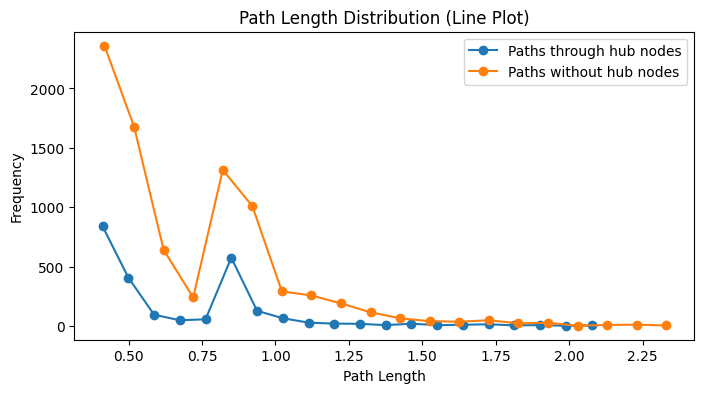

Mann-Whitney U test results for row 0: U=8274979.5, p-value=2.65128987516078e-32
Shortest paths #: hub:2355 / non-hub:8360


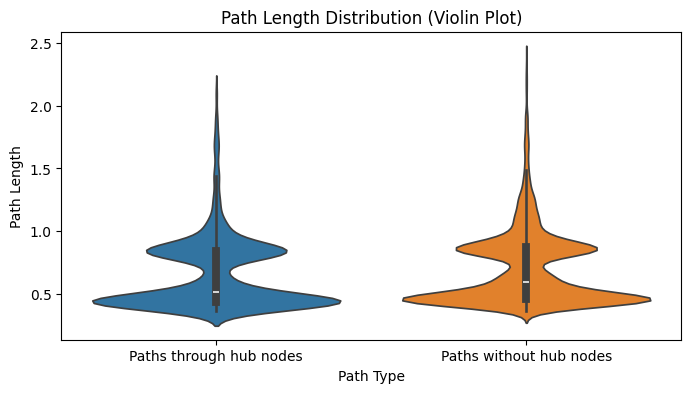

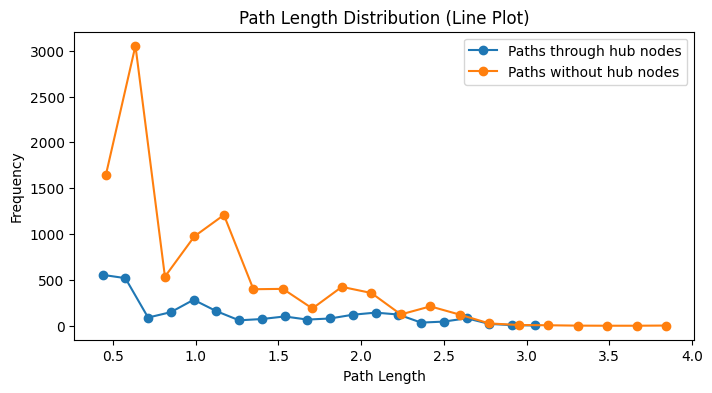

Mann-Whitney U test results for row 1: U=13190090.0, p-value=0.5999362724642154
Shortest paths #: hub:2706 / non-hub:9685


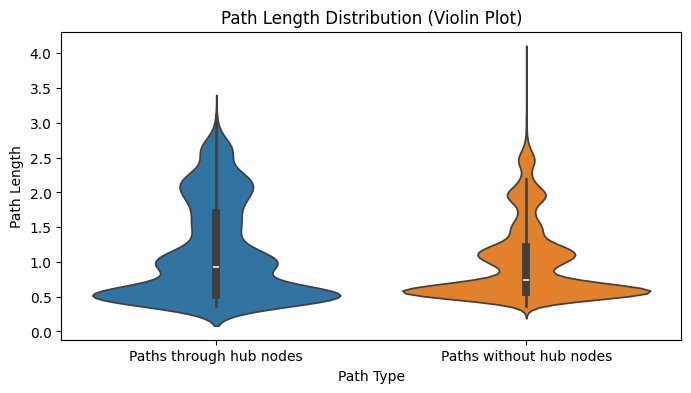

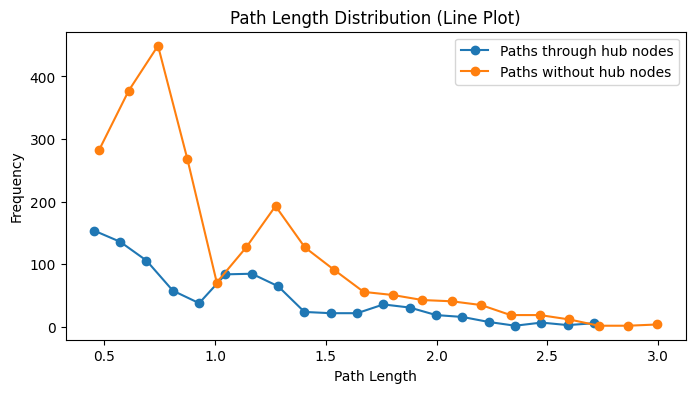

Mann-Whitney U test results for row 2: U=1008360.0, p-value=0.10633203742669298
Shortest paths #: hub:922 / non-hub:2270


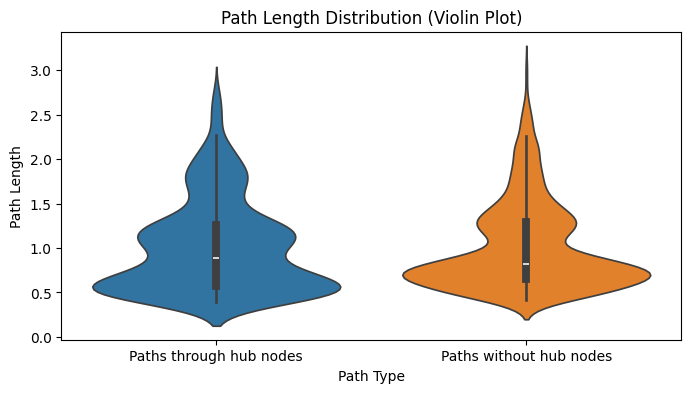

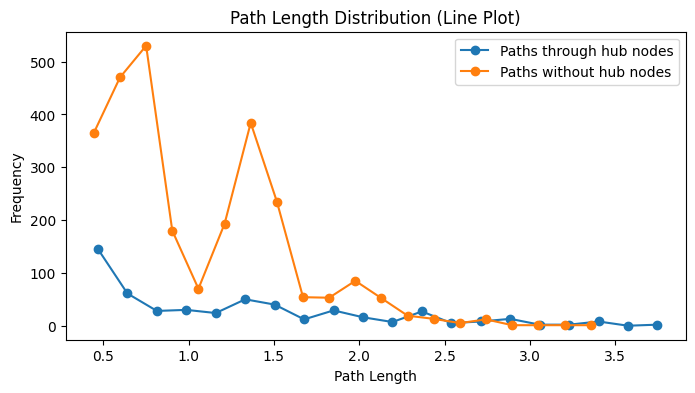

Mann-Whitney U test results for row 3: U=725421.0, p-value=0.09614715507324532
Shortest paths #: hub:509 / non-hub:2724


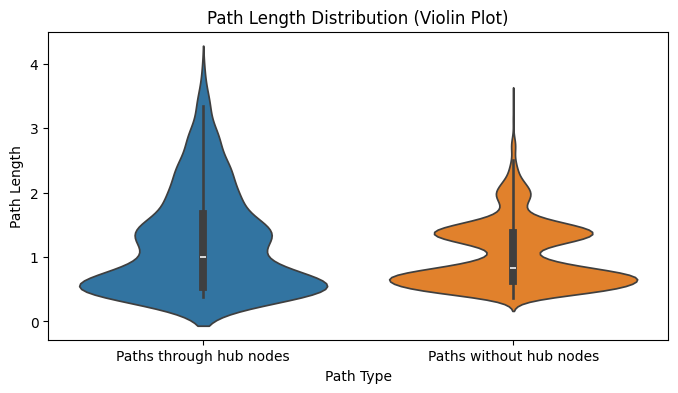

In [12]:
# 2. 뽑은 hub/non-hub로 나눠서 shortest path length를 hub 거치는 경우/안 거치는 경우로 나눔

for row_index, graphs in enumerate(w):
    utils.plot_path_lengths(row_index, graphs, high_degree_hub_list)

Shortest path length divided by the case of throuhg hub or not

Mann-Whitney U test results: U=4772007.0, p-value=2.0211756195984613e-205
Excitatory_hub
Mann-Whitney U test results: U=56641642.0, p-value=0.0
Excitatory_non-hub
Mann-Whitney U test results: U=256635.0, p-value=0.0033048612569865233
Inhibitory_hub
Mann-Whitney U test results: U=3124543.0, p-value=0.5179124081823321
Inhibitory_non-hub


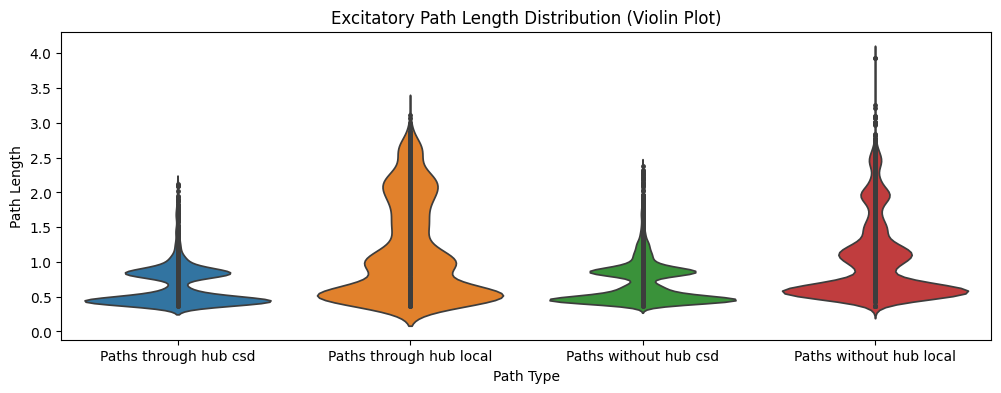

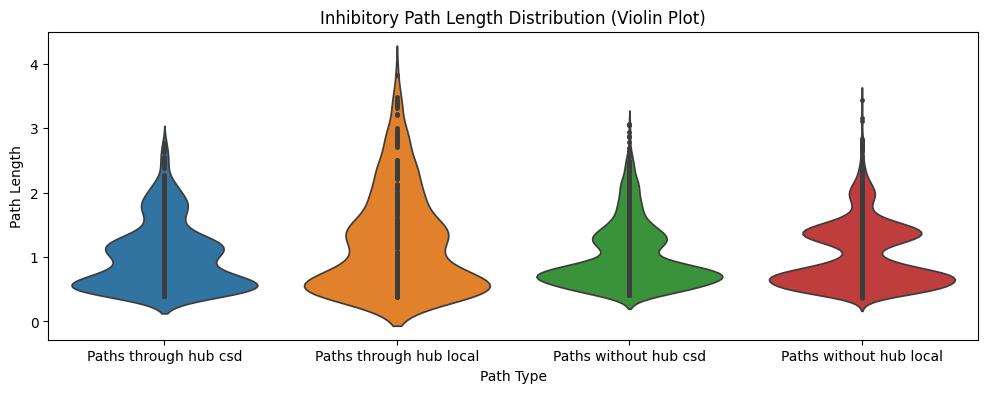

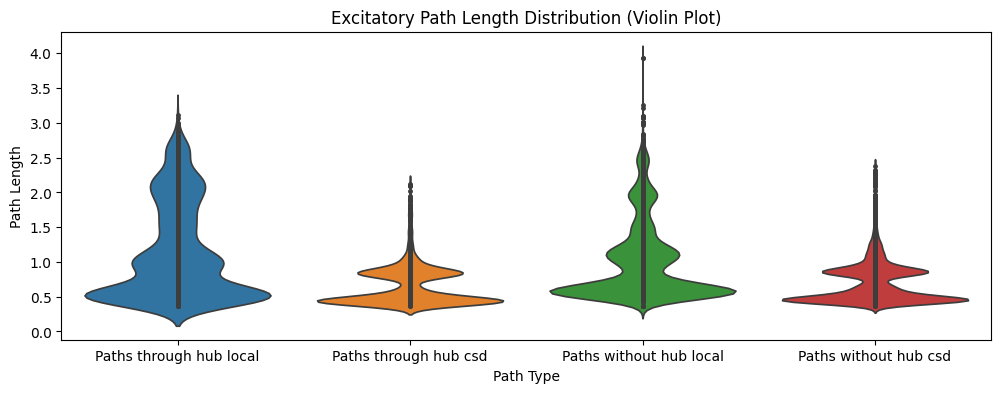

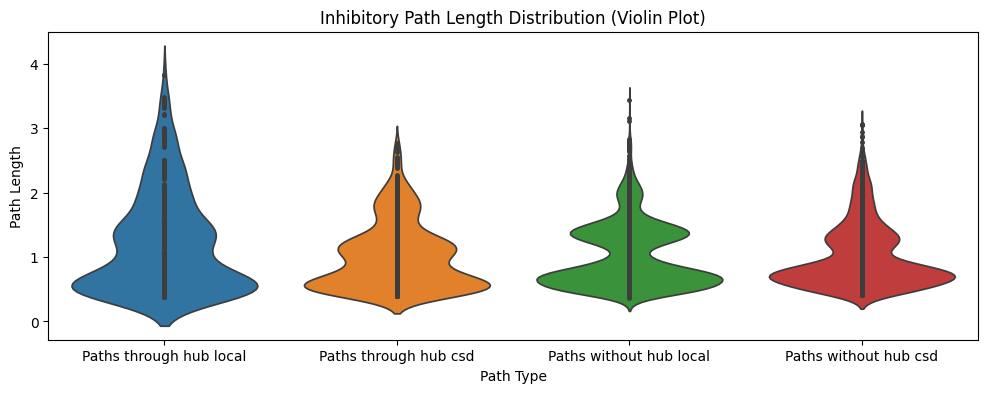

In [13]:
# Plot shortest path length of each excitatory & inhibitory neuronal network
utils.plot_path_lengths_exin_merge(w, high_degree_hub_list)

In [22]:
# Inhibitory neuron subtype indexs classified by support vector machine (SVM) 
pv_subtype_list=[[[],[],[3,6],[9],[19],[3, 16]], [[8],[],[27],[],[],[]]]
som_subtype_list=[[[],[21],[],[],[],[]], [[],[],[],[],[],[]]]
vip_subtype_list=[[[2, 10],[12],[5, 23, 28],[7, 17],[11, 17],[8]], [[],[28],[23],[7, 17],[10, 15, 16],[13]]]

# Addition info.) w[0]=excitatory csd, w[1]=excitatory local, w[2]=inhibitory csd, w[3]=inhibitory local
print('[PV]\n')
all_path_lengths_with_pv = utils.plot_path_lengths_in_subtype(w[2:4], pv_subtype_list, high_degree_hub_list[2:4])
print('[SOM]\n')
all_path_lengths_with_som = utils.plot_path_lengths_in_subtype(w[2:4], som_subtype_list, high_degree_hub_list[2:4])
print('[VIP]\n')
all_path_lengths_with_vip = utils.plot_path_lengths_in_subtype(w[2:4], vip_subtype_list, high_degree_hub_list[2:4])

[PV]

Mann-Whitney U test results: U=256635.0, p-value=0.0033048612569865233
Inhibitory_hub
Mann-Whitney U test results: U=3124543.0, p-value=0.5179124081823321
Inhibitory_non-hub


all_path_lengths_with_subtype: 2
[[0.5398382332136067, 1.1966719429148718, 0.5126504785496032, 1.1876091615705293, 0.5386448909977145, 0.5186095704383376, 0.6433973432439972, 0.4399179749046231, 0.4264289195929809, 0.5467204186053649, 0.5348165070260857, 0.7430590672024181, 0.46436870964618493, 0.5753516238833516, 0.44627699939877563, 0.49819319395650025, 0.6644796989947798, 0.9914843655971782, 1.1746541203539187, 1.0799631287519966, 1.1014850396450906, 1.0124014117147127, 1.0218492519303508, 1.6327517239199956, 1.8422285177909137, 1.5979750152171002, 1.8538858633490751, 2.0794016666614006, 1.780278144974811, 1.6138515494283894, 1.979625064689602, 2.5572224123320573, 1.0582357205841846, 1.3004265613015893, 0.4309300337006389, 1.1609658844647868, 1.129745385158559, 1.8225089306910398, 1.5782554281172263, 1.8

Mann-Whitney U test results: U=256635.0, p-value=0.0033048612569865233
Inhibitory_hub
Mann-Whitney U test results: U=3124543.0, p-value=0.5179124081823321
Inhibitory_non-hub


all_path_lengths_with_subtype: 2
[[0.5488018148321875, 1.0371625377274145, 1.2415066581184573, 1.7730286079756672, 1.7548126586917674, 1.8189413809149864, 0.9652861451552761, 0.6478550656432067, 1.3405599089294766, 1.5595718711676798, 1.9179946317260057, 0.6235959527275116, 1.1119566756227384, 1.3163007960137816, 1.8296067965870917, 1.8937355188103107, 1.8478227458709915, 2.479277170081681, 0.9922685651928591, 1.2935462364193815, 0.45534084186808393, 1.148045685154354, 1.661351685727664, 1.725480407950883, 0.5260462354260977, 1.0144069583213247, 1.2187510787123677, 1.7320570792856778, 1.7961858015088967, 1.7502730285695776, 2.381727452780267, 0.7251373017643621, 1.349291860961578, 1.4317596329377886, 0.7371390046400913, 1.4152851892618261, 1.9285911898351362, 1.9927199120583552, 0.4883607228952269, 0.508254058189

In [16]:
# Print the index of hubs
print(high_degree_hub_list)

[[[22, 24], [27, 21, 24], [20, 26, 33, 34], [30, 16, 18, 20, 26], [31, 21, 22, 28], [31, 15, 19, 20, 38, 46, 30, 40], [43, 27, 16, 32, 38, 25, 17], [35, 32, 18]], [[31, 24, 34], [13, 19], [22, 23], [42, 28], [40, 43], [46, 44, 34, 38, 40, 31, 42, 50], [38, 33, 34, 13, 16, 17, 36], [24, 27, 35, 12]], [[10, 2], [12, 28, 21], [6, 3, 5, 23, 28], [7, 9, 17], [11, 17, 19], [3, 16, 8]], [[8], [28], [23, 27], [7, 17], [16, 10, 15], [13]]]


Data export to excel & matlab

In [ ]:
def export_to_excel_single_sheet(pv_data, som_data, vip_data, file_name='path_lengths_subtype.xlsx'):
    # Create DataFrames from the data
    pv_df = pd.DataFrame(pv_data).transpose()
    som_df = pd.DataFrame(som_data).transpose()
    vip_df = pd.DataFrame(vip_data).transpose()

    # Concatenate DataFrames horizontally
    combined_df = pd.concat([pv_df, som_df, vip_df], axis=1)

    # Set column names
    combined_df.columns = ['PV_csd', 'PV_local', 'SOM_csd', 'SOM_local', 'VIP_csd', 'VIP_local']

    # Create a Pandas Excel writer using openpyxl as the engine
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        # Write the DataFrame to a single sheet
        combined_df.to_excel(writer, sheet_name='PathLengths', index=False)

# Example usage with the lists all_path_lengths_with_pv, all_path_lengths_with_som, all_path_lengths_with_vip
export_to_excel_single_sheet(all_path_lengths_with_pv, all_path_lengths_with_som, all_path_lengths_with_vip)

In [17]:
# !pip install openpyxl 
import pandas as pd
import openpyxl
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import scipy.io as sio

varname=['density','degDevlen','assort', 'bet_cent', 'clos_cent','clst_coeff', 'shortest_path', 'weight']
xlxs_dir='240625_CSD_crcorr_ExpCorrVal_ExpTimeshift_SharedNeuron_zeroAlign.xlsx'
wb = openpyxl.Workbook()


for i in range (0,len(varname)):
    
    main = pd.DataFrame({'Ex_CSD':pd.Series(globals()['W_Ex_CSD_{}'.format(varname[i])]), 
                        'Ex_Local': pd.Series(globals()['W_Ex_Local_{}'.format(varname[i])]),
                        'In_CSD': pd.Series(globals()['W_In_CSD_{}'.format(varname[i])]),
                        'In_Local': pd.Series(globals()['W_In_Local_{}'.format(varname[i])])})
   
    wb2 = wb.create_sheet(varname[i],-1)
    for r in dataframe_to_rows(main, index=True, header=True):
        wb2.append(r)

wb.save(xlxs_dir)

In [18]:
# Convert nested list to MATLAB format
matlab_data = {'W_Ex_CSD_weight': W_Ex_CSD_weight,
              'W_Ex_Local_weight': W_Ex_Local_weight,
              'W_In_CSD_weight': W_In_CSD_weight,
              'W_In_Local_weight': W_In_Local_weight}

sio.savemat('240625_CSD_crcorr_ExpCorrVal_ExpTimeshift_SharedNeuron_zeroAlign_weight,altered.mat', matlab_data)

In [19]:
# .Mat file for graph
import scipy.io as sio

Matname_delta=['ex_delta_CSDLocal', 'in_delta_CSDLocal']
Matname=['ex_CSD', 'ex_Local', 'in_CSD', 'in_Local']

matlab_data = {}

for i in range(2):
    key = Matname_delta[i]
    data = {
        'degree': (np.array(globals()[utils.retrieve_name(w[2*i])[0]+"_degDevlen"]) - np.array(globals()[utils.retrieve_name(w[2*i+1])[0]+"_degDevlen"])).tolist(),
        'between_cent': (np.array(globals()[utils.retrieve_name(w[2*i])[0]+"_bet_cent"]) - np.array(globals()[utils.retrieve_name(w[2*i+1])[0]+"_bet_cent"])).tolist(),
        'close_cent': (np.array(globals()[utils.retrieve_name(w[2*i])[0]+"_clos_cent"]) - np.array(globals()[utils.retrieve_name(w[2*i+1])[0]+"_clos_cent"])).tolist(),
        'eigen_cent': (np.array(globals()[utils.retrieve_name(w[2*i])[0]+"_ei_cent"]) - np.array(globals()[utils.retrieve_name(w[2*i+1])[0]+"_ei_cent"])).tolist(),
        'weight':{'both':weight_tot_mat[3*i],'csd_only': weight_tot_mat[3*i+1], 'local_only':weight_tot_mat[3*i+2]}
                   }
    
    matlab_data[key] = data
    
matlab_data['population_para'] = {}  # 'population_para' 키를 추가

for i in range(4):
    key = Matname[i]
    data = {
        'assortativity': globals()[utils.retrieve_name(w[i])[0]+"_assort"],
        'clustering_coeff': globals()[utils.retrieve_name(w[i])[0]+"_clst_coeff"],
        'density': globals()[utils.retrieve_name(w[i])[0]+"_density"]
    }
    matlab_data['population_para'][key] = data

sio.savemat('240625_CSD_directedNetwork_graphData.mat', matlab_data)
